In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import math
import json
import ccxt

In [2]:
def convert_tz(utc):
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = utc.replace(tzinfo = from_zone).astimezone(to_zone)
    
    return utc

In [3]:
def get_date_list(start_day):
    num_day = (dt.date.today() - start_day).days
    date_list = [dt.date.today() - dt.timedelta(days = x) for x in range(num_day, 0, -1)]
    return date_list

In [4]:
def get_ts_date(dt_date):
    dt_datetime = dt.datetime(dt_date.year, dt_date.month, dt_date.day)
    ts = dt_datetime.timestamp() * 1000
    
    return ts

In [5]:
def get_ohlcv(symbol, date_list, timeframe, limit):
    df = pd.DataFrame(columns = ['time', 'open', 'high', 'low', 'close', 'volume'])

    for i in range(len(date_list)):
        since = get_ts_date(date_list[i])
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        df_temp = pd.DataFrame(ohlcv)
        df_temp.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        df_temp['time'] = pd.to_datetime(df_temp['time'], unit = 'ms')
        df_temp['time'] = df_temp['time'].apply(lambda x: convert_tz(x))

        df = pd.concat([df, df_temp])

    df = df.reset_index(drop = True)

    return df

In [6]:
def get_timeframe(period):
    timeframe_dict = {1440:'1d', 240:'4h', 60:'1h', 30:'30m', 15:'15m'}
    
    for i in timeframe_dict.keys():
        if period % i == 0:
            min_period = i
            break
            
    min_timeframe = timeframe_dict[min_period]
    step = int(period / min_period)
            
    return min_timeframe, step

In [7]:
def group_timeframe(df, step):
    h_dict = {'time':[], 'open':[], 'high':[], 'low':[], 'close':[]}
    
    mod = len(df) % step
    if  mod != 0:
        df = df.iloc[:-mod, :]
        
    for i in [x for x in range(0, len(df), step)]:
        df_temp = df.iloc[i:i + step, :]
        h_dict['time'].append(df_temp['time'][i])
        h_dict['open'].append(df_temp['open'][i])
        h_dict['high'].append(max(df_temp['high']))
        h_dict['low'].append(min(df_temp['low']))
        h_dict['close'].append(df_temp['close'][i + 1])

    df = pd.DataFrame(h_dict)
    
    return df

In [8]:
def get_signal(df, signal, interval):
    func_dict = {'tma': signal_tma}
    
    df = func_dict[signal](df, interval)
    
    return df

In [9]:
def signal_tma(df, interval):
    df['ma'] = df['close'].rolling(window = math.trunc(interval)).mean()
    df['signal'] = df['ma'].rolling(window = math.trunc(interval)).mean()
    df = df.drop(columns = ['ma'])
    df = df.dropna().reset_index(drop = True)
    
    return df

In [10]:
def round_down_amount(amount, decimal):
    floor_amount = np.floor((amount * (10 ** decimal))) / (10 ** decimal)
    
    return floor_amount

### Config 

In [11]:
with open('../../../_keys/ftx/ftx_test_keys.json') as keys_file:
    keys_dict = json.load(keys_file)

In [12]:
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

In [13]:
base_currency = 'ETH'
quote_currency = 'USD'
decimal = 3

In [14]:
file_path = 'data'

In [15]:
signal = 'tma'
period = 120
interval = 50

In [16]:
start_date = dt.date(2020, 1, 1)

### Get timeframe 

In [17]:
min_timeframe, step = get_timeframe(period)

In [18]:
limit = int(1440 / (period / step))

### Get data

In [19]:
symbol = '{}/{}'.format(base_currency, quote_currency)

In [20]:
date_list = get_date_list(start_date)

In [21]:
df_raw = get_ohlcv(symbol, date_list, min_timeframe, limit)

In [22]:
df_raw

,time,open,high,low,close,volume
0,2020-01-01 00:00:00+07:00,129.62,129.63,128.24,128.75,5.453050e+01
1,2020-01-01 01:00:00+07:00,128.76,129.41,128.46,128.84,0.000000e+00
2,2020-01-01 02:00:00+07:00,128.84,128.84,127.94,127.98,1.998859e+03
3,2020-01-01 03:00:00+07:00,127.95,128.37,127.70,127.84,9.212380e+02
4,2020-01-01 04:00:00+07:00,127.84,128.52,127.75,128.41,0.000000e+00
...,...,...,...,...,...,...
13387,2021-07-11 19:00:00+07:00,2129.40,2138.80,2120.50,2123.40,5.689400e+06
13388,2021-07-11 20:00:00+07:00,2123.40,2135.80,2113.10,2135.80,4.444128e+06
13389,2021-07-11 21:00:00+07:00,2135.80,2148.30,2127.30,2145.80,7.610563e+06
13390,2021-07-11 22:00:00+07:00,2145.80,2150.50,2134.50,2145.60,4.536010e+06


### Group timeframe

In [23]:
df = group_timeframe(df_raw, step)

In [24]:
df

,time,open,high,low,close
0,2020-01-01 00:00:00+07:00,129.62,129.63,128.24,128.84
1,2020-01-01 02:00:00+07:00,128.84,128.84,127.70,127.84
2,2020-01-01 04:00:00+07:00,127.84,128.76,127.75,128.50
3,2020-01-01 06:00:00+07:00,128.51,128.85,128.16,128.36
4,2020-01-01 08:00:00+07:00,128.36,130.47,128.29,130.37
...,...,...,...,...,...
6691,2021-07-11 14:00:00+07:00,2091.40,2120.00,2087.40,2111.80
6692,2021-07-11 16:00:00+07:00,2111.80,2134.60,2107.60,2120.60
6693,2021-07-11 18:00:00+07:00,2120.60,2138.80,2116.00,2123.40
6694,2021-07-11 20:00:00+07:00,2123.40,2148.30,2113.10,2145.80


### Get signal

In [25]:
df = get_signal(df, signal, interval)

In [26]:
df

,time,open,high,low,close,signal
0,2020-01-09 04:00:00+07:00,139.05,140.45,138.58,140.37,135.020728
1,2020-01-09 06:00:00+07:00,140.37,141.32,139.62,139.93,135.213780
2,2020-01-09 08:00:00+07:00,139.93,141.46,139.76,140.36,135.407328
3,2020-01-09 10:00:00+07:00,140.36,140.36,139.53,140.03,135.600256
4,2020-01-09 12:00:00+07:00,140.03,140.03,138.84,139.55,135.792092
...,...,...,...,...,...,...
6593,2021-07-11 14:00:00+07:00,2091.40,2120.00,2087.40,2111.80,2256.954520
6594,2021-07-11 16:00:00+07:00,2111.80,2134.60,2107.60,2120.60,2254.967040
6595,2021-07-11 18:00:00+07:00,2120.60,2138.80,2116.00,2123.40,2252.777960
6596,2021-07-11 20:00:00+07:00,2123.40,2148.30,2113.10,2145.80,2250.405760


### Run simulation 

In [27]:
df_simu = df.copy()

In [28]:
budget = 100
last_action_price = 0
last_action_amount = 0

In [29]:
signal_dict = {'action':[], 'action_price':[], 'budget':[], 'profit':[], 'drawdown':[]}

for i in range(len(df_simu)):
    if df['close'][i] > df['signal'][i]:
        action = 'buy'
    elif df['close'][i] < df['signal'][i]:
        action = 'sell'
    else:
        action = signal_dict['action'][-1]
    
    if i > 0:
        if action != signal_dict['action'][-1]:
            if last_action_price > 0:
                if action == 'buy':
                    profit = (last_action_price - df['close'][i]) * last_action_amount
                elif action == 'sell':
                    profit = (df['close'][i] - last_action_price) * last_action_amount

            last_action_price = df['close'][i]
            last_action_amount = round_down_amount(budget / last_action_price, decimal)
            
            budget += profit
        else:
            profit = 0
    else:
        profit = 0
        
    
    if last_action_price > 0:
        if action == 'buy':
            drawdown = (df['low'][i] - last_action_price) / last_action_price
        elif action == 'sell':
            drawdown = (last_action_price - df['high'][i]) / last_action_price
    else:
        drawdown = 0
        max_drawdown = 0
        
    signal_dict['action'].append(action)
    signal_dict['action_price'].append(last_action_price)
    signal_dict['budget'].append(budget)
    signal_dict['profit'].append(profit)
    signal_dict['drawdown'].append(drawdown)

In [30]:
budget

479.2235000000002

In [31]:
for s in signal_dict.keys():
    df_simu[s] = signal_dict[s]

In [32]:
df_simu.to_csv('simulation.csv', index = False)

### Viz 

In [33]:
import matplotlib.pyplot as plt

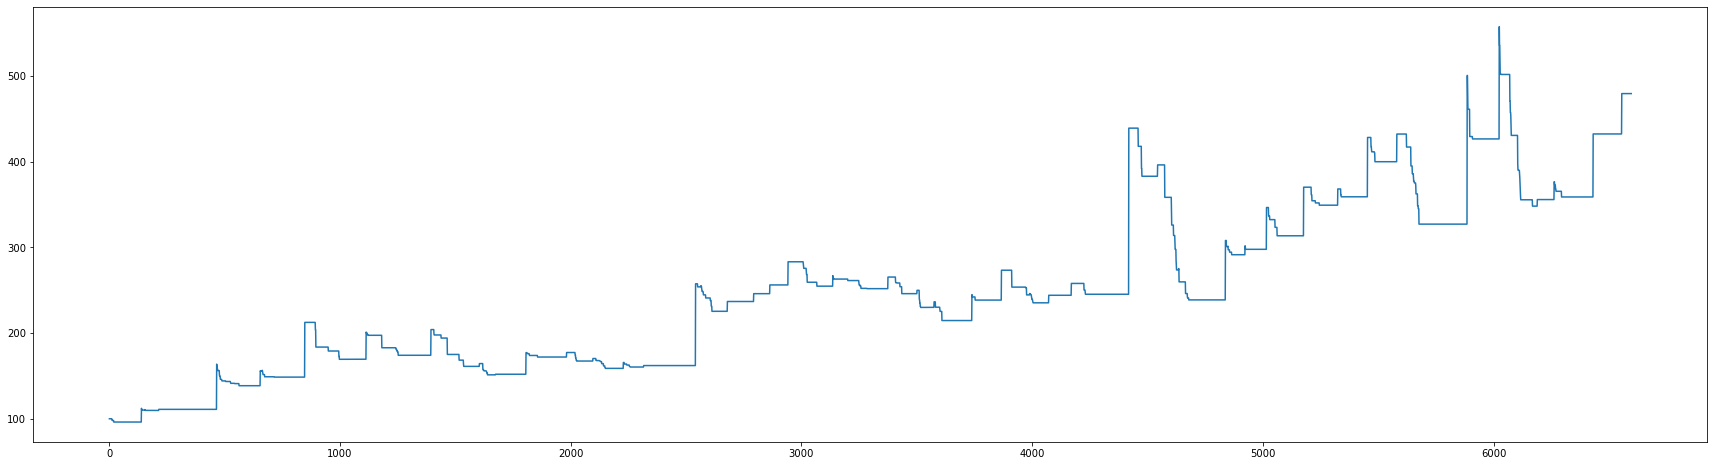

In [34]:
fig, ax = plt.subplots(figsize=(30,8))
ax.plot(df_simu['budget'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   2.,   0.,
          1.,   3.,   2.,   5.,   3.,   1.,  10.,   5.,   7.,   5.,   3.,
          5.,   5.,  10.,   4.,   6.,   9.,   8.,   9.,   9.,   7.,  12.,
          7.,  16.,   9.,   6.,  15.,  11.,  15.,  27.,  21.,  25.,  18.,
         24.,  19.,  25.,  38.,  37.,  42.,  45.,  54.,  67.,  66.,  60.,
         63.,  87.,  97., 137., 102., 108.,  85.,  66.,  63.,  75.,  78.,
         68.,  65.,  49.,  62.,  68.,  42.,  47.,  59.,  47.,  51.,  51.,
         53.,  62.,  53.,  52.,  32.,  44.,  54.,  50.,  38.,  40.,  40.,
         41.,  36.,  43.,  29.,  38.,  27.,  27.,  36.,  41.,  43.,  49.,
         35.,  27.,  32.,  34.,  24.,  29.,  21.,  29.,  24.,  26.,  34.,
         38.,  22.,  29.,  32.,  33., 

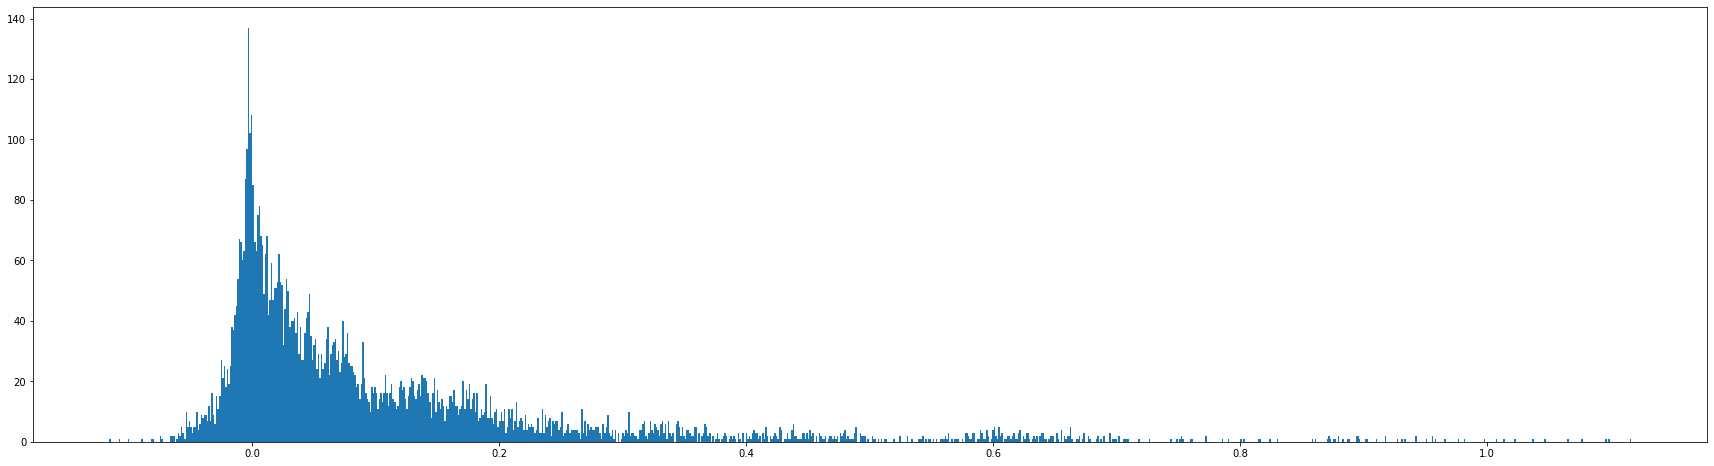

In [35]:
fig, ax = plt.subplots(figsize=(30,8))
ax.hist(df_simu['drawdown'], bins=1000)

In [36]:
df_simu['drawdown'].describe()

count    6598.000000
mean        0.105667
std         0.161103
min        -0.115483
25%         0.005008
50%         0.047469
75%         0.143012
max         1.116935
Name: drawdown, dtype: float64